In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import wrangle_mall
from env import get_db_url
import os
from matplotlib import style
style.use('ggplot')
from sklearn.model_selection import train_test_split

In [2]:

def get_mall_data(use_cache=True):
    """pull from SQL unless mall_data.csv exists"""
    filename = "mall_data.csv"
    if os.path.isfile(filename) and use_cache:
        print("Reading from csv...")
        return pd.read_csv(filename)

    print("reading from sql...")
    url = get_db_url('mall_customers')
    query = '''
    SELECT *
    From customers'''
    mall_df = pd.read_sql(query, url, index_col='customer_id')
    print("Saving to csv in local directory...")
    mall_df.to_csv(filename, index=False)
    return mall_df

In [3]:
df = get_mall_data()

Reading from csv...


In [4]:
df.head()

,gender,age,annual_income,spending_score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [5]:
def basic_info(df):
    print(df.info())
    print(df.describe())
    print('\n')
    print('null counts:')
    print(df.isnull().sum())

In [6]:
basic_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB
None
              age  annual_income  spending_score
count  200.000000     200.000000      200.000000
mean    38.850000      60.560000       50.200000
std     13.969007      26.264721       25.823522
min     18.000000      15.000000        1.000000
25%     28.750000      41.500000       34.750000
50%     36.000000      61.500000       50.000000
75%     49.000000      78.000000       73.000000
max     70.000000     137.000000       99.000000


null counts:
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64


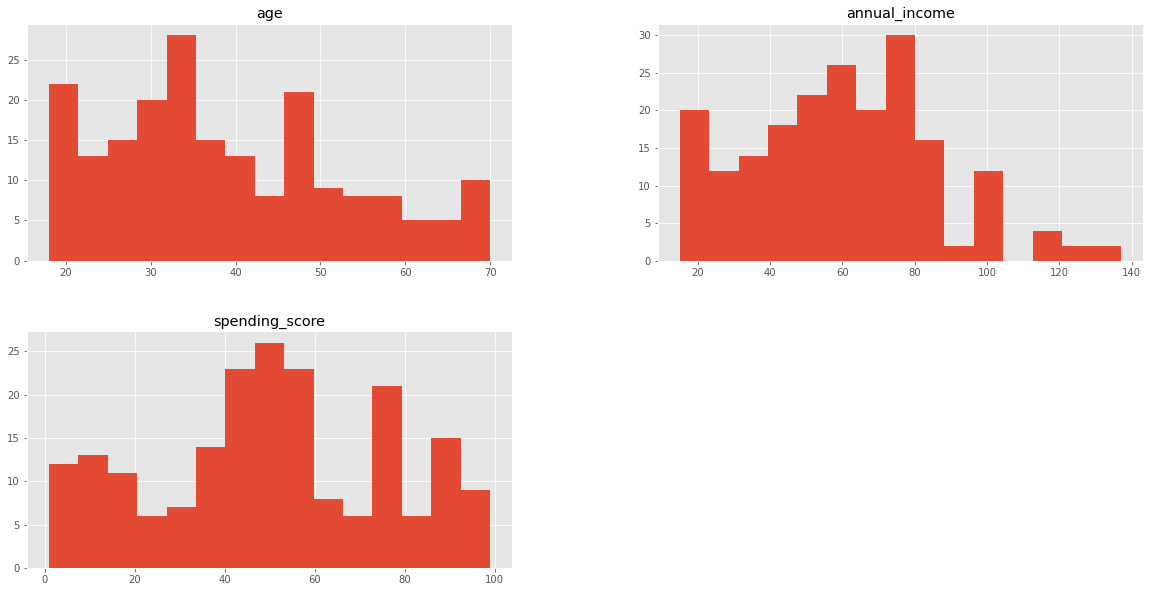

In [7]:
df.hist(figsize=(20,10), bins= 15)
plt.show()

<AxesSubplot:ylabel='spending_score'>

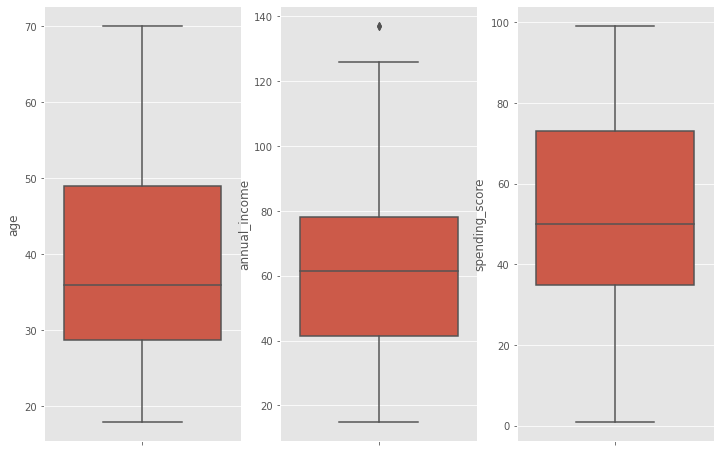

In [8]:
# visualize outliers using boxplots:

plt.figure(figsize = (12,8))
plt.subplot(131)
sns.boxplot(y = df.age)

plt.subplot(132)
sns.boxplot(y = df.annual_income)

plt.subplot(133)
sns.boxplot(y = df.spending_score)

In [9]:
def detect_outliers(df, col, k = 1.5):
    '''look for outliers in a column of a dataframe using IQR, k'''
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (iqr * k)
    upper_bound = q3 + (iqr * k)
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

In [10]:
# look at all quantitative variables:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    print(col)
    print(detect_outliers(df, col))
    print('\n')

age
Empty DataFrame
Columns: [gender, age, annual_income, spending_score]
Index: []


annual_income
    gender  age  annual_income  spending_score
198   Male   32            137              18
199   Male   30            137              83


spending_score
Empty DataFrame
Columns: [gender, age, annual_income, spending_score]
Index: []




In [11]:
def remove_outliers(df, k=1.5):
    '''remove outliers from all quantitative variables'''
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df = df[~df[col].index.isin(detect_outliers(df, col, k).index)]
    return df

In [12]:
df = remove_outliers(df)
df.shape

(198, 4)

In [13]:
# double check the two outliers are gone
detect_outliers(df, 'annual_income')

,gender,age,annual_income,spending_score


In [14]:
def encode_categoricals(df):
    '''encode categorical variables using dummy variables'''
    for col in df.select_dtypes(include=['object']).columns:
        df = pd.get_dummies(df, columns=[col], drop_first=True)
    return df

In [15]:
df = encode_categoricals(df)
df.head()

,age,annual_income,spending_score,gender_Male
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


In [16]:
def split_data(df):
    '''split data into train, validate and test sets'''
    train, test = train_test_split(df, test_size=0.2, random_state=42)
    train, validate = train_test_split(train, test_size=0.3, random_state=42)
    return train, validate, test

In [17]:
train, validate, test = split_data(df)
train.head(), train.shape

(     age  annual_income  spending_score  gender_Male
 130   47             71               9            1
 42    48             39              36            1
 79    49             54              42            0
 28    40             29              31            0
 54    50             43              45            0,
 (110, 4))

no missing values as determined above

In [18]:
def scale_numerical(train, validate, test, scaler=StandardScaler()):
    '''scale numerical variables after fitting on training set'''
    # choose numerical columns
    numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns
    #fit and transform training data
    train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
    # transform validation data
    validate[numerical_cols] = scaler.transform(validate[numerical_cols])
    # transform test data
    test[numerical_cols] = scaler.transform(test[numerical_cols])
    return train, validate, test

In [19]:
train, validate, test = scale_numerical(train, validate, test)
train.head(),train.shape

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


(          age  annual_income  spending_score  gender_Male
 130  0.651655       0.531929       -1.622245            1
 42   0.725783      -0.755823       -0.547503            1
 79   0.799912      -0.152189       -0.308672            0
 28   0.132757      -1.158245       -0.746529            0
 54   0.874040      -0.594854       -0.189256            0,
 (110, 4))

Lets test all the functions from wrangle_mall.py

In [20]:
#test all the functions in wrangle_mall.py
df = wrangle_mall.get_mall_data()



Reading from csv...


In [21]:
wrangle_mall.basic_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB
None
              age  annual_income  spending_score
count  200.000000     200.000000      200.000000
mean    38.850000      60.560000       50.200000
std     13.969007      26.264721       25.823522
min     18.000000      15.000000        1.000000
25%     28.750000      41.500000       34.750000
50%     36.000000      61.500000       50.000000
75%     49.000000      78.000000       73.000000
max     70.000000     137.000000       99.000000


null counts:
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64


In [22]:
wrangle_mall.detect_outliers(df, 'annual_income')

,gender,age,annual_income,spending_score
198,Male,32,137,18
199,Male,30,137,83


In [23]:
df = wrangle_mall.remove_outliers(df)

In [24]:
df= wrangle_mall.encode_categoricals(df)

In [25]:
train, validate, test = wrangle_mall.split_data(df)

In [26]:
train, validate, test = wrangle_mall.scale_numerical(train, validate, test)

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [27]:
train.head()

,age,annual_income,spending_score,gender_Male
130,0.651655,0.531929,-1.622245,1
42,0.725783,-0.755823,-0.547503,1
79,0.799912,-0.152189,-0.308672,0
28,0.132757,-1.158245,-0.746529,0
54,0.874040,-0.594854,-0.189256,0


In [28]:
validate.head()

,age,annual_income,spending_score,gender_Male
48,-0.682654,-0.715580,-0.308672,0
127,0.132757,0.531929,1.801007,1
129,-0.015500,0.531929,1.004902,1
179,-0.237884,1.417259,1.601980,1
94,-0.460269,0.089265,-0.308672,0


In [29]:
test.head()

,age,annual_income,spending_score,gender_Male
65,-1.498065,-0.393642,0.368018,1
114,-1.498065,0.290476,-0.069840,0
16,-0.237884,-1.480183,-0.587308,0
141,-0.460269,0.692898,1.721396,1
156,-0.089628,0.813625,-1.940687,1


In [30]:
train, validate, test = wrangle_mall.wrangle(df)

Reading from csv...


/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [31]:
train.head()

,age,annual_income,spending_score,gender_Male
130,0.651655,0.531929,-1.622245,1
42,0.725783,-0.755823,-0.547503,1
79,0.799912,-0.152189,-0.308672,0
28,0.132757,-1.158245,-0.746529,0
54,0.874040,-0.594854,-0.189256,0
